# 1. Importing Dataset and Installing Dataset

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor


In [55]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


# 1.1 Installing Dataset

In [56]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [57]:
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

In [58]:
len(train_data), len(test_data)

(60000, 10000)

In [59]:
data_classes = train_data.classes
data_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# 1.2 Visualizing our data

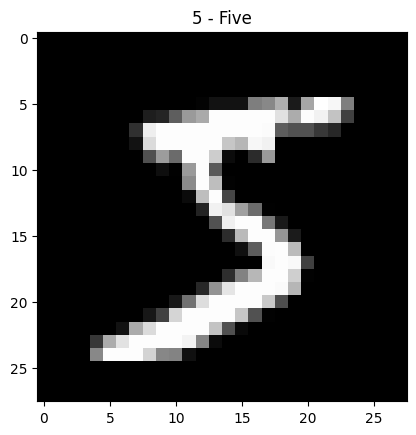

In [60]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(data_classes[label].title())
plt.show()

In [61]:
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

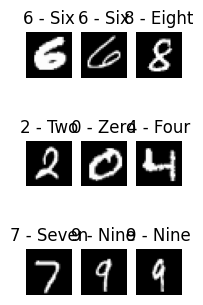

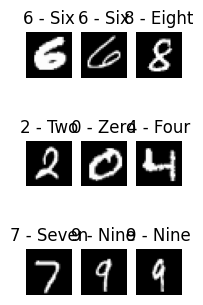

In [62]:
torch.manual_seed(42)

fig = plt.figure(figsize=(2,4))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(data_classes[label].title())
    plt.axis(False)

plt.show(False)

In [63]:
class MNISTV1(nn.Module):
    def __init__(self, input_shape, hidden_unit, output_shape):
        super(MNISTV1, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                      out_channels=hidden_unit,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_unit, hidden_unit, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*7*7, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

model = MNISTV1(input_shape=1, hidden_unit=10, output_shape=len(data_classes))

In [64]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [66]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Accuracy
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_acc += acc

        # Backward pass + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [67]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Accuracy
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")


In [68]:
def print_timer(start_time, end_time, device):
    time = end_time - start_time
    print(f"Time taken: {time:.3f} seconds on {device}")


In [69]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

epochs = 3
start_time = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")

    train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer,
               device=device)

    test_step(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

end_time = timer()

print_timer(start_time, end_time, device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.30970 | Train accuracy: 89.52%
Test loss: 0.09077 | Test accuracy: 97.14%
Epoch: 1
---------
Train loss: 0.08627 | Train accuracy: 97.28%
Test loss: 0.06173 | Test accuracy: 97.95%
Epoch: 2
---------
Train loss: 0.06638 | Train accuracy: 97.92%
Test loss: 0.04688 | Test accuracy: 98.46%
Time taken: 175.018 seconds on cpu


In [72]:
def model_eval(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            batch_loss = loss_fn(y_pred, y).item()
            batch_acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

            total_loss += batch_loss
            total_acc += batch_acc

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": avg_loss,
        "model_acc": avg_acc
    }


In [74]:
model_eval(model=model, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

{'model_name': 'MNISTV1',
 'model_loss': 0.046877237120486116,
 'model_acc': 98.46246006389777}

In [75]:
def make_predict(model: torch.nn.Module,
                 data: list,
                 device: torch.device = device):
    pred_prob = []

    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(0).to(device)  # Shape: [1, 1, 28, 28]
            pred_logit = model(sample)               # Shape: [1, 10]
            pred_p = torch.softmax(pred_logit, dim=1).squeeze(0)  # Shape: [10]
            pred_prob.append(pred_p.cpu())  # Move to CPU if needed

    return torch.stack(pred_prob)  # Shape: [N, 10]


In [77]:
class_names =  train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [113]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (5 - five)


In [114]:
predicted_data = make_predict(model=model, data=test_samples, device=device)

In [115]:
predict = predicted_data.argmax(dim=1)
predict

tensor([5, 3, 4, 6, 0, 6, 5, 6, 1])

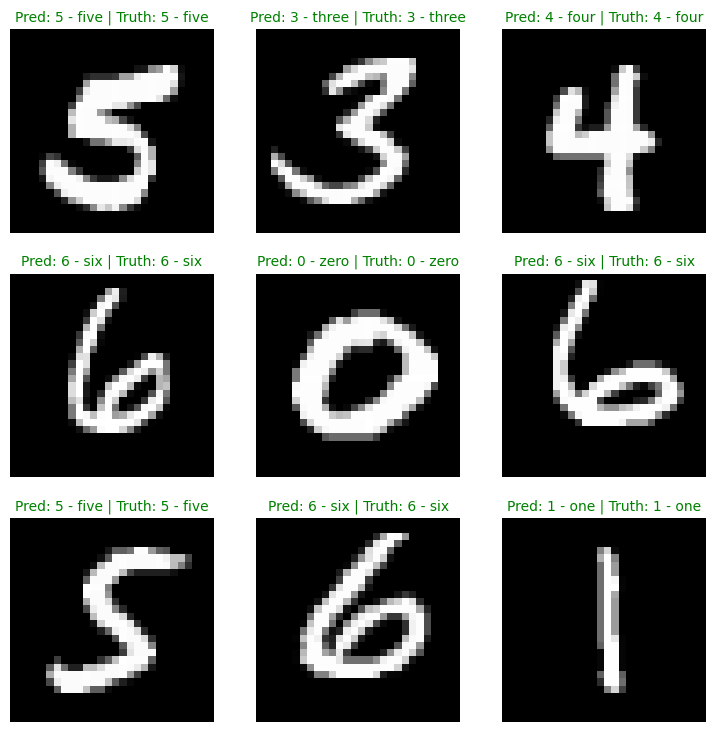

In [116]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label
  pred_label = class_names[predict[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);